In [ ]:
!pip install datasets

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import yfinance as yf
from datasets import load_dataset
import re


In [ ]:
# ds = load_dataset("prasanna660/financial-headlines2")

# # Convert the dataset to a pandas DataFrame
# df = ds['train'].to_pandas()

# # Define a function to clean and split the text
# def clean_text(row):
#     text = row['text']  # Adjust column name if needed
    
#     # Extract news outlet
#     news_outlet_match = re.search(r'Headline from (Reuters|Guardian|CNBC)', text)
#     news_outlet = news_outlet_match.group(1) if news_outlet_match else None
    
#     # Extract date
#     if news_outlet == "Reuters":
#         date_match = re.search(r'on (.*?):', text)
#     elif news_outlet == "Guardian":
#         date_match = re.search(r'on (.*?):', text)
#     elif news_outlet == "CNBC":
#         date_match = re.search(r'on .*?, (.*?):', text)
#     else:
#         date_match = None
#     date = date_match.group(1) if date_match else None
    
#     # Normalize date format (optional)
#     if date:
#         try:
#             date = pd.to_datetime(date).strftime('%Y-%m-%d')
#         except:
#             pass
    
#     # Extract headline
#     headline_match = re.search(r'on .*?: (.*?) Description:', text)
#     if not headline_match:  # Guardian may not have a description
#         headline_match = re.search(r'on .*?: (.*?)<\|eot_id\|>', text)
#     headline = headline_match.group(1) if headline_match else None
    
#     # Extract description
#     description_match = re.search(r'Description: (.*?)<\|eot_id\|>', text)
#     description = description_match.group(1) if description_match else None
    
#     return pd.Series([news_outlet, date, headline, description])

# # Apply the cleaning function to the dataset
# df[['news_outlet', 'date', 'headline', 'description']] = df.apply(clean_text, axis=1)

# # Drop the original text column if not needed
# df.drop(columns=['text'], inplace=True)

# Save the cleaned DataFrame to a CSV
# df.to_csv("fin_headlines_clean.csv", index=False)

The code above downloads the dataset and clean the data. For practical reasons, the cleaned dataset is saved to a csv file, which will be loaded in the next cell.

In [91]:
df = pd.read_csv("fin_headlines_clean.csv")

# Delete rows with missing values
df.dropna(inplace=True)

# set date as index
df.set_index('date', inplace=True)

# Display the cleaned DataFrame
display(df.head())
display(df.tail())

,news_outlet,headline,description
date,,,
2020-07-18,Reuters,TikTok considers London and other locations fo...,TikTok has been in discussions with the UK gov...
2020-07-18,Reuters,Disney cuts ad spending on Facebook amid growi...,Walt Disney has become the latest company to ...
2020-07-18,Reuters,Trail of missing Wirecard executive leads to B...,Former Wirecard chief operating officer Jan M...
2020-07-18,Reuters,Twitter says attackers downloaded data from up...,Twitter Inc said on Saturday that hackers were...
2020-07-17,Reuters,U.S. Republicans seek liability protections as...,A battle in the U.S. Congress over a new coron...


,news_outlet,headline,description
date,,,
2017-12-26,CNBC,Markets lack Christmas cheer,"According to Kensho, here's how markets have f..."
2018-09-20,CNBC,Cramer Remix: The biggest mistake you can make...,Jim Cramer revealed his top rule when it comes...
2017-12-22,CNBC,Cramer says owning too many stocks and too lit...,Jim Cramer broke down why owning fewer stocks ...
2017-12-22,CNBC,Cramer: I helped investors through the 2010 fl...,"Jim Cramer built on his ""nobody ever made a di..."
2017-12-22,CNBC,Cramer: Never buy a stock all at once — you'll...,Jim Cramer doubled down on his key investing r...


Next we will load the finbert-tone model so we can use it on our dataset.

In [92]:
# Load model
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")

This next step takes about 30 minutes to run. So a csv file with the results is provided next.

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from tqdm import tqdm

# Load FinBERT model and tokenizer
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone', num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

# Initialize the sentiment analysis pipeline
nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)

# Function for sentiment analysis
def analyze_sentiment(text):
    result = nlp(text)[0]  # Get the first result
    label = result['label']  # Extract the label
    score = result['score']  # Extract the score
    return label, score

# Add new columns to the DataFrame with a progress bar
tqdm.pandas(desc="Analyzing Sentiment")
df[['h.label', 'h.score']] = df['headline'].progress_apply(lambda x: pd.Series(analyze_sentiment(x)))

# Sort the DataFrame by index (optional)
df = df.sort_index(ascending=True)

# Display the processed DataFrame
display(df)
# df.to_csv('fin_headlines_sentiment.csv')

In [97]:
display(df['h.label'].value_counts())

display(df)

h.label
Neutral     22385
Negative     8078
Positive     5105
Name: count, dtype: int64

,news_outlet,headline,description,h.label,h.score
date,,,,,
2017-12-22,CNBC,Cramer: Never buy a stock all at once — you'll...,Jim Cramer doubled down on his key investing r...,Neutral,0.599732
2017-12-22,CNBC,Cramer: I helped investors through the 2010 fl...,"Jim Cramer built on his ""nobody ever made a di...",Positive,0.990638
2017-12-22,CNBC,Cramer says owning too many stocks and too lit...,Jim Cramer broke down why owning fewer stocks ...,Negative,0.959445
2017-12-26,CNBC,Markets lack Christmas cheer,"According to Kensho, here's how markets have f...",Negative,0.999711
2017-12-27,CNBC,S&P tends to start new year bullish after this...,The S&P is on track to end the year up 20 perc...,Neutral,0.999728
...,...,...,...,...,...
2020-07-17,Reuters,Former Pemex boss Lozoya taken to hospital aft...,"Emilio Lozoya, a former boss of Mexican state ...",Neutral,0.999398
2020-07-18,Reuters,Twitter says attackers downloaded data from up...,Twitter Inc said on Saturday that hackers were...,Neutral,0.999975
2020-07-18,Reuters,Trail of missing Wirecard executive leads to B...,Former Wirecard chief operating officer Jan M...,Neutral,0.963038


In [116]:
# filter out the neutral headlines
dfn = df[df['h.label'] != 'Neutral']
dfn = dfn.drop(columns=['description'])

# Multiply the score by -1 when the label is negative and by 1 when the label is positive
dfn['h.score'] = dfn['h.score'] * dfn['h.label'].apply(lambda x: -1 if x == 'Negative' else 1)

# Order date in ascending order
dfn = dfn.sort_index(ascending=True)

# Display the processed DataFrame
display(dfn)
display(dfn['h.label'].value_counts())

,news_outlet,headline,h.label,h.score,sentiment_score
date,,,,,
2017-12-22,CNBC,Cramer: I helped investors through the 2010 fl...,Positive,0.990638,0.990638
2017-12-22,CNBC,Cramer says owning too many stocks and too lit...,Negative,-0.959445,0.959445
2017-12-26,CNBC,Markets lack Christmas cheer,Negative,-0.999711,0.999711
2018-01-02,CNBC,The major indexes trade lower in January,Negative,-0.628967,0.628967
2018-01-02,CNBC,Cramer's S&P 500 and Dow charts indicate a str...,Positive,1.000000,1.000000
...,...,...,...,...,...
2020-07-17,Reuters,Fed opens 'Main Street' loan program to nonpro...,Positive,0.553229,0.553229
2020-07-17,Reuters,Exclusive: Pact to aid poor cocoa farmers in p...,Negative,-0.999217,0.999217
2020-07-17,Reuters,Wall Street analysts look past Netflix's weak ...,Negative,-0.999981,0.999981


h.label
Negative    8078
Positive    5105
Name: count, dtype: int64

In [130]:
# Explicitly handle sentiment label adjustment
def adjust_score(row):
    if row['h.label'] == 'Positive':
        return row['h.score']  # Positive scores remain as is
    elif row['h.label'] == 'Negative':
        return -row['h.score']  # Negative scores are multiplied by -1
    else:
        return 0  # Neutral or missing scores are set to 0 (ignored in trend)

# Apply the adjustment function
df['adjusted_score'] = df.apply(adjust_score, axis=1)

# Group by date and calculate the mean adjusted sentiment score for each day
sentiment_trend = df.groupby('date')['adjusted_score'].mean()

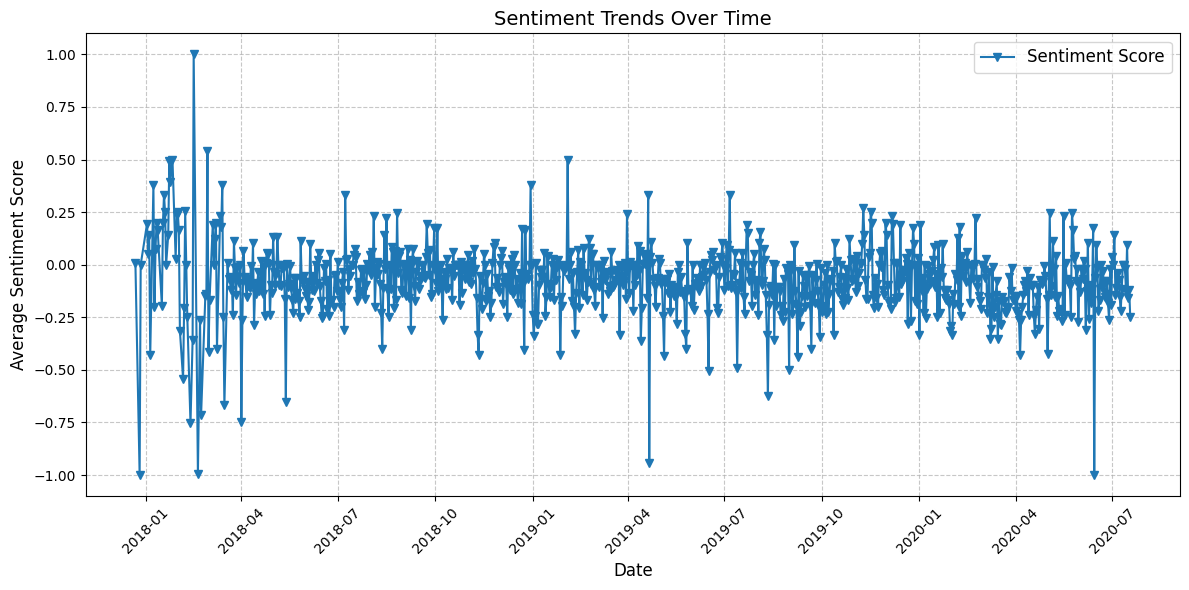

In [132]:
sentiment_trend.index = pd.to_datetime(sentiment_trend.index)

# Plot sentiment trends
plt.figure(figsize=(12, 6))
plt.plot(sentiment_trend.index, sentiment_trend.values, marker='v', linestyle='-', label='Sentiment Score')
plt.title('Sentiment Trends Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Sentiment Score', fontsize=12)

# Format x-axis for better readability
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Show year and month
# plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show every 3 months
plt.xticks(rotation=45, fontsize=10)

# Add grid and legend
plt.grid(visible=True, which='major', linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

In [133]:
display(sentiment_trend)

date
2017-12-22    0.010398
2017-12-26   -0.999711
2017-12-27    0.000000
2018-01-02    0.195309
2018-01-03    0.050583
                ...   
2020-07-14   -0.126378
2020-07-15    0.095113
2020-07-16   -0.159322
2020-07-17   -0.118235
2020-07-18   -0.249982
Name: adjusted_score, Length: 905, dtype: float64

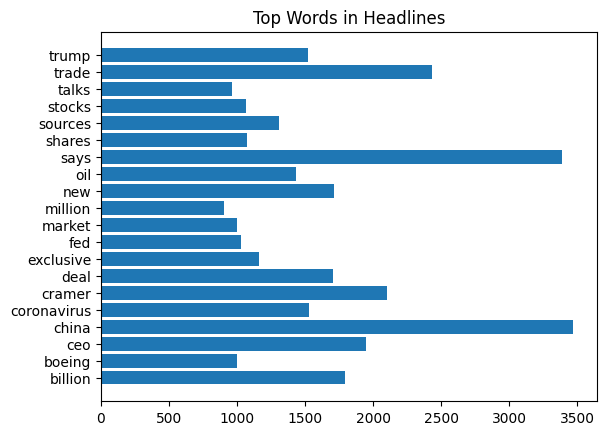

In [134]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', max_features=20)
top_words = vectorizer.fit_transform(df['headline']).toarray().sum(axis=0)
words = vectorizer.get_feature_names_out()

plt.barh(words, top_words)
plt.title('Top Words in Headlines')
plt.show()

Now it will be interesting to see what is the daily sentiment of the headlines. We will plot that against the S&P 500 returns and their volatility to check if there is any correlation between them.

In [268]:
# Get historical stock data
spy = yf.Ticker('SPY')
spy_data = spy.history(start='2020-01-15', end='2020-07-18')

# Calculate log returns using the 'Close' price
spy_data['log_return'] = spy_data['Close'].pct_change().apply(lambda x: np.log(1 + x))

# Calculate volatility
spy_data['volatility'] = spy_data['log_return'].rolling(window=20).std()

In [269]:
df_spy = spy_data[['Close', 'log_return', 'volatility']]
display(df_spy.head(10))

,Close,log_return,volatility
Date,,,
2020-01-15 00:00:00-05:00,305.297058,NaN,NaN
2020-01-16 00:00:00-05:00,307.836609,0.008284,NaN
2020-01-17 00:00:00-05:00,308.794800,0.003108,NaN
2020-01-21 00:00:00-05:00,308.190155,-0.001960,NaN
2020-01-22 00:00:00-05:00,308.227264,0.000120,NaN
2020-01-23 00:00:00-05:00,308.580811,0.001146,NaN
2020-01-24 00:00:00-05:00,305.836578,-0.008933,NaN
2020-01-27 00:00:00-05:00,300.934174,-0.016159,NaN
2020-01-28 00:00:00-05:00,304.087738,0.010425,NaN


In [270]:
# Normalize df_spy index to remove timezone information and convert to date-only format
df_spy.index = pd.to_datetime(df_spy.index).date

# Convert sentiment_trend to a DataFrame
sentiment_trend_df = pd.DataFrame(sentiment_trend)

# Merge sentiment_trend_df into df_spy
df_spy = df_spy.merge(sentiment_trend_df, how='left', left_index=True, right_index=True)

# Display the updated DataFrame
display(df_spy.head(10))

,Close,log_return,volatility,adjusted_score
2020-01-15,305.297058,NaN,NaN,0.084136
2020-01-16,307.836609,0.008284,NaN,-0.104580
2020-01-17,308.794800,0.003108,NaN,-0.043132
2020-01-21,308.190155,-0.001960,NaN,-0.016117
2020-01-22,308.227264,0.000120,NaN,-0.060222
2020-01-23,308.580811,0.001146,NaN,0.100547
2020-01-24,305.836578,-0.008933,NaN,-0.118691
2020-01-27,300.934174,-0.016159,NaN,-0.118805
2020-01-28,304.087738,0.010425,NaN,-0.167832
2020-01-29,303.836548,-0.000826,NaN,-0.185142


In [271]:
# Shift the sentiment_score column by 1 to align it with the next day's return
df_spy['prev_sentiment_score'] = df_spy['adjusted_score'].shift(1)

df_spy = df_spy.dropna()

# Check the correlation between prev_sentiment_score and the current day's log return
corr_return = df_spy[['prev_sentiment_score', 'log_return']].corr().iloc[0, 1]
print(f"Correlation between previous day's sentiment score and current day's return: {corr_return}")

# Check the correlation between prev_sentiment_score and the current day's volatility
corr_vol = df_spy[['prev_sentiment_score', 'volatility']].corr().iloc[0, 1]
print(f"Correlation between previous day's sentiment score and current day's volatility: {corr_vol}")

# Display the updated DataFrame
display(df_spy.head(10))

Correlation between previous day's sentiment score and current day's return: -0.08431530523083505
Correlation between previous day's sentiment score and current day's volatility: -0.4202041045750178


,Close,log_return,volatility,adjusted_score,prev_sentiment_score
2020-02-13,313.548340,-0.001067,0.008585,0.007455,-0.005269
2020-02-14,314.050690,0.001601,0.008429,-0.081264,0.007455
2020-02-18,313.241394,-0.002580,0.008450,-0.182270,-0.081264
2020-02-19,314.739014,0.004770,0.008472,-0.000003,-0.182270
2020-02-20,313.446014,-0.004117,0.008549,-0.006645,-0.000003
2020-02-21,310.217987,-0.010352,0.008907,-0.069382,-0.006645
2020-02-24,299.929504,-0.033728,0.011579,-0.104185,-0.069382
2020-02-25,290.841064,-0.030771,0.012965,-0.066467,-0.104185
2020-02-26,289.771271,-0.003685,0.012651,-0.146613,-0.066467
2020-02-27,276.757172,-0.045951,0.015947,-0.174450,-0.146613
